# AK4 Tagger

In [1]:
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from time import time

In [2]:
dir_path = os.path.join("C:/", "Shared", "Tesi magistrale", "databases", "stable")
if(os.path.exists(dir_path) and os.path.isdir(dir_path)):
    print("Found!")
else:
    print("!!! NOT FOUND !!!")
    #files_names = [f for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f))]
    #for f in files_names:
        #print('\t%s' % f)

Found!


In [3]:
def get_raw_data(file_path):
    try:
        in_file = open(file_path, 'r')  #TODO: Add an header row in the csv builder (DBGenerator.cc)
        raw_data = pd.read_csv(in_file, delimiter=',', header=None) #raw_data is a pandas.DataFrame
    except IOError as e:
        print(e)
        return None
    else:
        in_file.close()
        return raw_data

In [4]:
def drawPoints(source, **kwargs):
    errTrain = [source[a]['train'] for a in source.keys()]
    errTest = [source[a]['test'] for a in source.keys()]
    print(source.keys())
    plt.title(kwargs.get("title", "Default Tittle"))
    plt.scatter(source.keys(), errTest, label='test')
    plt.scatter(source.keys(), errTrain, label='train')
    if(kwargs.get("logx", True)):
        plt.xlabel('log10(%s)' % kwargs.get("xlabel", "x axis"))
        plt.gca().set_xscale('log')
    else:
        plt.xlabel(kwargs.get("xlabel", "x axis"))
    plt.ylabel(kwargs.get("ylabel", "Error"))
    plt.legend()
    pass

In [5]:
def grid_plot(data, nx, ny, **kwargs): #n_ = range of _
    scores = data.reshape(ny.shape[0], nx.shape[0])
    title = kwargs.get("title", "Title")
    
    if(kwargs.get("log", True)):
        scores = np.vectorize(lambda x: -math.log10(1-x))(scores)
        title += " (-log(1-x))"
        #title.join(" (-log(1-x))")

    plt.figure(figsize=(8, 8))

    plt.imshow(scores, interpolation='nearest', origin='lower')#, cmap=plt.cm.hot)
    plt.title(title)
    if(kwargs.get("logx", True)):
        plt.xlabel('log10(%s)' % kwargs.get("lx", "lx"))
        plt.xticks(np.arange(len(nx)), map(lambda x : round(math.log10(x),2), nx))
    else:
        plt.xlabel(kwargs.get("lx", "lx"))
        plt.xticks(np.arange(len(nx)), map(lambda x: round(x,2), nx))
    
    if(kwargs.get("logy", True)):
        plt.ylabel('log10(%s)' % kwargs.get("ly", "ly"))
        plt.yticks(np.arange(len(ny)), map(lambda x : round(math.log10(x),2), ny))
    else:
        plt.ylabel(kwargs.get("ly", "ly"))
        plt.yticks(np.arange(len(ny)), map(lambda x: round(x,3), ny))
    plt.colorbar()

In [6]:
def overf_log(grid):
    if(grid.cv_results_.get('mean_train_score') is None):
        print("Error: mean_train_score not found")
        return
    if(grid.cv_results_.get('mean_test_score') is None):
        print("Error: mean_test_score not found")
        return
    overfit = (grid.cv_results_['mean_train_score'] - grid.cv_results_['mean_test_score'])
    index = np.argmax(grid.cv_results_['mean_test_score'])
    print("Score at best params: %.3f" % (grid.cv_results_['mean_test_score'][index]))
    print("Overfit at best params = %.2g" % (overfit[index]))

## VZZ

In [7]:
from sklearn.model_selection import train_test_split

AK4_VZZ_raw = get_raw_data(os.path.join(dir_path, "VZZ_1618_TagAK4.csv"))
feat4_raw   = AK4_VZZ_raw.drop(0, axis=1).drop(1, axis=1)
target4_VZZ = AK4_VZZ_raw[0]
weight4_VZZ = AK4_VZZ_raw[1]

AK4_VZZ = AK4_VZZ_raw[(AK4_VZZ_raw[1]>0)]

feat4_VZZ = AK4_VZZ.drop(0, axis=1).drop(1, axis=1)
target4_VZZ   = AK4_VZZ[0]
weight4_VZZ   = AK4_VZZ[1]

X4_VZZ_train, X4_VZZ_valid, y4_VZZ_train, y4_VZZ_valid = train_test_split(feat4_VZZ, target4_VZZ.to_numpy(), test_size=0.2, random_state=42)
#TODO shuffle
print("n_samples:", AK4_VZZ.shape[0], "  Features:", feat4_VZZ.shape[1])
print("Train size:", y4_VZZ_train.shape[0], "  Validation size:", y4_VZZ_valid.shape[0])

print("--------------------------------------")
nz = np.count_nonzero(target4_VZZ.to_numpy())
print('"1" =', nz, '\n"0" =', len(target4_VZZ) - nz)
del nz

n_samples: 2896   Features: 19
Train size: 2316   Validation size: 580
--------------------------------------
"1" = 1222 
"0" = 1674


In [10]:
from sklearn.ensemble import AdaBoostClassifier
#from sklearn.tree import DecisionTreeClassifier
#from sklearn import tree

ErrAda = {}
AdaBoost = AdaBoostClassifier(random_state=42, learning_rate=0.01)
start = time()

for ntrees in np.logspace(1.5, 4.0, 12).astype(int): #[1, 3, 5, 10, 25, 30, 35, 40, 45]:
    #start = time()
    AdaBoost.set_params(**{"n_estimators": ntrees})
    AdaBoost.fit(X4_VZZ_train, y4_VZZ_train)
    
    train_score = AdaBoost.score(X4_VZZ_train, y4_VZZ_train)
    test_score  = AdaBoost.score(X4_VZZ_valid, y4_VZZ_valid)
    #print("Score in = %.3f - Score out = %.3f - Elapsed Time = %.2f s" % (train_score, test_score, time()-start))
    ErrAda[ntrees] = {'train': 1-train_score, 'test': 1-test_score}

print("Elapsed Time = %.2f s" % (time() - start))

Elapsed Time = 176.37 s


dict_keys([31, 53, 90, 151, 256, 432, 730, 1232, 2080, 3511, 5925, 10000])


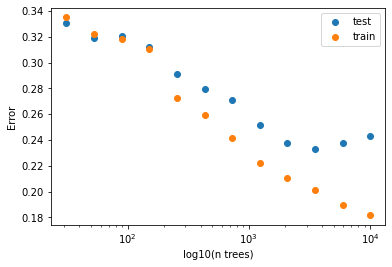

In [12]:
#err vs n_iterations
drawPoints(ErrAda, title="", xlabel="n trees", logx=True)

In [18]:
ErrAda_l = {}
AdaBoost_l = AdaBoostClassifier(random_state=42, n_estimators=1500)
start = time()

for lrate in np.logspace(0, -3., 12):
    #start = time()
    AdaBoost_l.set_params(**{"learning_rate": lrate})
    AdaBoost_l.fit(X4_VZZ_train, y4_VZZ_train)
    
    train_score = AdaBoost_l.score(X4_VZZ_train, y4_VZZ_train)
    test_score  = AdaBoost_l.score(X4_VZZ_valid, y4_VZZ_valid)
    #print("Score in = %.3f - Score out = %.3f - Elapsed Time = %.2f s" % (train_score, test_score, time()-start))
    ErrAda_l[lrate] = {'train': 1-train_score, 'test': 1-test_score}

print("Elapsed Time = %.2f s" % (time() - start))

Elapsed Time = 139.76 s


dict_keys([1.0, 0.533669923120631, 0.2848035868435802, 0.1519911082952934, 0.08111308307896872, 0.04328761281083059, 0.023101297000831605, 0.012328467394420665, 0.006579332246575682, 0.0035111917342151347, 0.001873817422860385, 0.001])


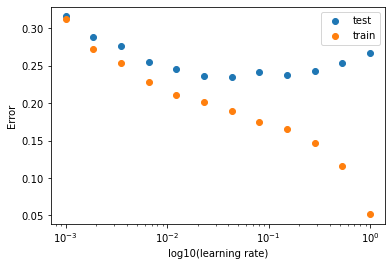

In [20]:
drawPoints(ErrAda_l, title="", xlabel="learning rate", logx=True)

In [23]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

AdaBoost = AdaBoostClassifier(random_state=42)
nTrees_Ada = np.logspace(3.0, 3.4, 5).astype(int)  #np.logspace(3.5, 4.0, 6).astype(int)
lRate_Ada  = np.logspace(-1.5, -1.1, 5)  #np.logspace(-2.4, -2.0, 5)
with np.printoptions(formatter={'float': lambda x: '%.3g' %(x)}):
    print("nTrees =", nTrees_Ada, "\t\t(", np.vectorize(lambda x: math.log10(x))(nTrees_Ada), ")")
    print("lRate =" , lRate_Ada , "\t(", np.vectorize(lambda x: math.log10(x))(lRate_Ada) , ")")

grid_Ada = GridSearchCV(AdaBoost, param_grid={'n_estimators': nTrees_Ada, 'learning_rate': lRate_Ada}, 
                            verbose=10, scoring='roc_auc', cv=5, n_jobs=-1, return_train_score=True)

start = time()
grid_Ada.fit(feat4_VZZ, target4_VZZ)#, sample_weight=weight4)
sec = time() - start
print("Elapsed time: %.0f s (%d\'%.d\")" % (sec, (int)(sec/60), int(sec)%60))
nTrees_best_Ada = grid_Ada.best_params_['n_estimators']
lRate_best_Ada  = grid_Ada.best_params_['learning_rate']
print ("best parameter choice: nTrees = %d (10^%.2g)" % (nTrees_best_Ada, math.log10(nTrees_best_Ada)))
print ("best parameter choice: lRate  = %.3g (10^%.2g)" % (lRate_best_Ada, math.log10(lRate_best_Ada)))

nTrees = [1000 1258 1584 1995 2511] 		( [3 3.1 3.2 3.3 3.4] )
lRate = [0.0316 0.0398 0.0501 0.0631 0.0794] 	( [-1.5 -1.4 -1.3 -1.2 -1.1] )
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   46.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed: 10.2min finished


Elapsed time: 623 s (10'22")
best parameter choice: nTrees = 1584 (10^3.2)
best parameter choice: lRate  = 0.0501 (10^-1.3)


Best score = 82.1109 %


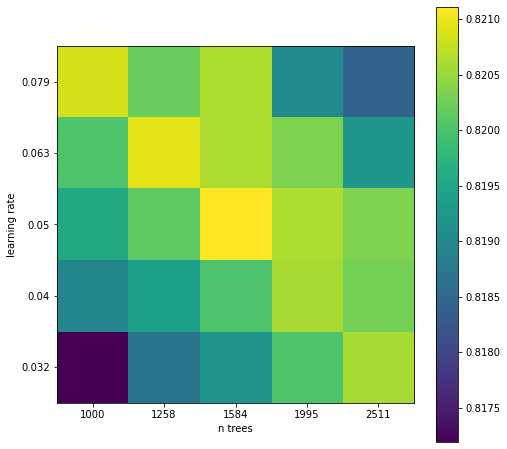

In [30]:
grid_plot(grid_Ada.cv_results_['mean_test_score'], nTrees_Ada, lRate_Ada, 
          lx="n trees", ly="learning rate", title="",#"AdaBoost - Score", 
          log=False, logx=False, logy=False)
print("Best score = %.4f %%" % (grid_Ada.best_score_*100))
if(nTrees_best_Ada==nTrees_Ada[0]):
    print("Limit on nTrees: optimal may be lower")
elif(nTrees_best_Ada==nTrees_Ada[-1]):
    print("Limit on nTrees: optimal may be higher")
if(lRate_best_Ada==lRate_Ada[0]):
    print("Limit on lRate:  optimal may be lower")
elif(lRate_best_Ada==lRate_Ada[-1]):
    print("Limit on lRate:  optimal may be higher")

Score at best params: 0.821
Overfit at best params = 0.073


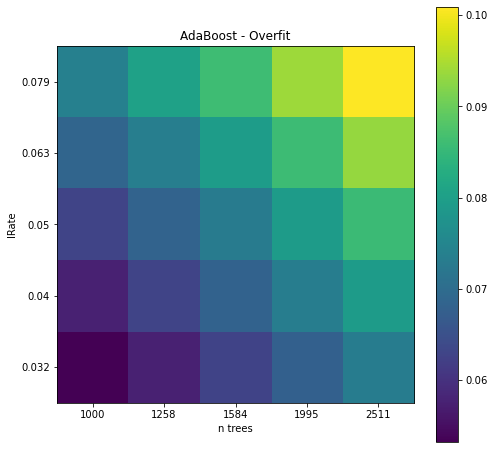

In [32]:
overfit = (grid_Ada.cv_results_['mean_train_score']-grid_Ada.cv_results_['mean_test_score'])
overf_log(grid_Ada)
grid_plot(overfit, nTrees_Ada, lRate_Ada, title="AdaBoost - Overfit", lx="n trees", ly="lRate", 
          logx=False, logy=False, log=False)
#Score at best params: 0.821
#Overfit at best params = 0.073

In [8]:
from sklearn.ensemble import AdaBoostClassifier

#Ada_VZZ = AdaBoostClassifier(n_estimators=nTrees_best_Ada, learning_rate=lRate_best_Ada, random_state=42)
#Ada_VZZ = AdaBoostClassifier(n_estimators=7943, learning_rate=0.004, random_state=42)
Ada_VZZ = AdaBoostClassifier(n_estimators=1584, learning_rate=0.05, random_state=42)
start = time()
Ada_VZZ.fit(X4_VZZ_train, y4_VZZ_train)
print("Elapsed time: %.3g s" % (time()-start))

Elapsed time: 10.4 s


90 % eff --> fpr= 49.9 %


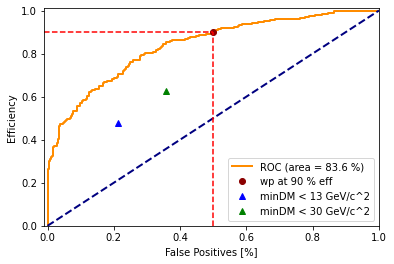

In [11]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y4_VZZ_valid, Ada_VZZ.predict_proba(X4_VZZ_valid)[:, 1])
auc_testVZZ = auc(fpr, tpr)

eff = 0.90
wp_fpr = fpr[np.searchsorted(tpr, eff, side='right')]

plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC (area = %.1f %%)' % (100*auc_testVZZ), linestyle='-')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.plot((wp_fpr), (eff), 'o', color='darkred', label='wp at %.0f %% eff' % (eff*100))
plt.plot((0.214019),(0.478722), "b^", label="minDM < 13 GeV/c^2")
plt.plot((0.356657),(0.624044), "g^", label="minDM < 30 GeV/c^2")
plt.plot((-0.01, wp_fpr),(eff, eff), "r--")
plt.plot((wp_fpr, wp_fpr),(0, eff), "r--")

plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positives [%]')
plt.ylabel('Efficiency')
#plt.title('ROC AK4 in VZZ (Validation)')
plt.legend(loc="lower right")

print('%.0f %% eff --> fpr= %.1f %%' % (eff*100, wp_fpr*100))

In [16]:
i_classic = np.searchsorted(fpr, 0.214019, side='right')
print("< 13 GeV/c^2 ", (0.214019*100, 0.478722*100, tpr[i_classic]*100))
i_classic = np.searchsorted(fpr, 0.356657, side='right')
print("< 30 GeV/c^2 ", (0.356657*100, 0.624044*100, tpr[i_classic]*100))

< 13 GeV/c^2  (21.401899999999998, 47.8722, 70.46413502109705)
< 30 GeV/c^2  (35.6657, 62.4044, 84.38818565400844)


In [34]:
# Working point at 95% efficiency
i_wp = np.searchsorted(tpr, 0.95, side='right')
print("----- Working point at efficiency = 95 % -----")
print("Index: %i/%i" % (i_wp, len(thresholds)))
print('False positives: %.2f%% - threshold: %.3g' % (fpr[i_wp]*100, thresholds[i_wp]))
print("----- ----- ----- ----- ----- ----- ----- -----\n")

i_wp = np.searchsorted(tpr, 0.9, side='right')
print("----- Working point at efficiency = 90 % -----")
print("Index: %i/%i" % (i_wp, len(thresholds)))
print('False positives: %.2f %% - threshold: %.3g' % (fpr[i_wp]*100, thresholds[i_wp]))
print("----- ----- ----- ----- ----- ----- ----- -----")

----- Working point at efficiency = 95 % -----
Index: 168/190
False positives: 65.89% - threshold: 0.495
----- ----- ----- ----- ----- ----- ----- -----

----- Working point at efficiency = 90 % -----
Index: 146/190
False positives: 49.85 % - threshold: 0.496
----- ----- ----- ----- ----- ----- ----- -----


In [29]:
# Features importance
#Ada_VZZ.set_params(**{"n_estimators": nTrees_best_Ada, "learning_rate": lRate_best_Ada})
#Ada_VZZ.set_params(**{"n_estimators": 7943, "learning_rate": 0.004})
#start = time()
#Ada_VZZ.fit(feat4_VZZ, target4_VZZ)
print("Elapsed time: %.3g s" % (time()-start))
print(Ada_VZZ.feature_importances_)

Elapsed time: 11.6 s
[0.05934343 0.05366162 0.12626263 0.03409091 0.06186869 0.0719697
 0.08522727 0.0770202  0.03724747 0.02020202 0.03787879 0.07133838
 0.0864899  0.01073232 0.02209596 0.02840909 0.03030303 0.05618687
 0.02967172]


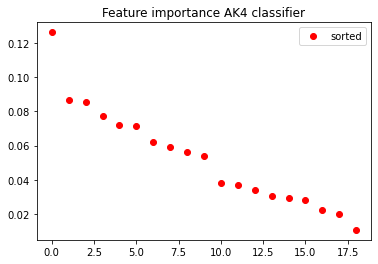

In [30]:
#plt.plot(AdaBoost.feature_importances_, "ro")
plt.plot(np.sort(Ada_VZZ.feature_importances_)[::-1], "ro", label='sorted')
plt.title("Feature importance AK4 classifier")
plt.legend()
pass

In [35]:
from pickle import Pickler

#Ada4 = AdaBoostClassifier(n_estimators=nTrees_best_Ada, learning_rate=lRate_best_Ada, random_state=42)
Ada4 = AdaBoostClassifier(n_estimators=1584, learning_rate=0.05, random_state=42)
start=time()
Ada4.fit(feat4_VZZ, target4_VZZ)
print("Training time = %.3g s" % (time() - start))
obj_path = os.path.join("C:/", "Shared", "VZZ_AK4_tree.pkl")

with open(obj_path, mode='w+b') as file: # "C:/Shared/VZZ_AK4_tree.pkl"
    pickler = Pickler(file)#, protocol=3)
    pickler.dump(Ada4)
    del pickler

size=os.stat(obj_path).st_size
j = math.floor(math.log(size,2)/10)
print("File size: %.3g %sB  (at %s)" % (size/1024**j, ['','K','M','G'][j], obj_path))
del size, j

Training time = 12.6 s
File size: 1.01 MB  (at C:/Shared\VZZ_AK4_tree.pkl)


In [6]:
from pickle import Unpickler

obj_path = os.path.join("C:/", "Shared", "VZZ_AK4_tree.pkl")
with open(obj_path, mode='rb') as file:
    unpickler = Unpickler(file)
    loaded_Ada4 = unpickler.load()
    del unpickler

#print("Loaded Object ID: %d   Ada ID: %d   Same? %s" % (id(loaded_Ada4), id(Ada4), id(loaded_Ada4)==id(Ada4)))

In [11]:
Ada4 = AdaBoostClassifier(n_estimators=1584, learning_rate=0.05, random_state=42)
start=time()
Ada4.fit(feat4_VZZ, target4_VZZ)
print("Training time = %.3g s" % (time() - start))

Training time = 14.5 s


In [12]:
live_pred = Ada4.predict_proba(feat4_VZZ)[:,1]
#loaded_pred = loaded_Ada4.predict_proba(feat4_VZZ)[:,1]

90 % eff --> fpr= 36.4 %


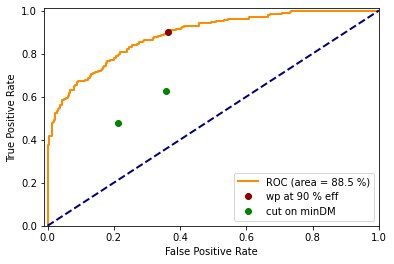

In [59]:
from sklearn.metrics import roc_curve, auc

#fpr, tpr, thresholds = roc_curve(target4_VZZ, loaded_pred)
fpr, tpr, thresholds = roc_curve(y4_VZZ_valid, Ada_VZZ.predict_proba(X4_VZZ_valid)[:, 1])
auc_testVZZ = auc(fpr, tpr)

eff = 0.90
wp_fpr = fpr[np.searchsorted(tpr, eff, side='right')]

plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC (area = %.1f %%)' % (100*auc_testVZZ), linestyle='-')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.plot((wp_fpr), (eff), 'o', color='darkred', label='wp at %.0f %% eff' % (eff*100))
plt.plot((0.214019, 0.356657),(0.478722, 0.624044), "go", label="cut on minDM")
#plt.plot((0.356657),(0.624044), "go", label="cut on minDM")
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('ROC AK4 in VZZ (Validation)')
plt.legend(loc="lower right")

print('%.0f %% eff --> fpr= %.1f %%' % (eff*100, wp_fpr*100))

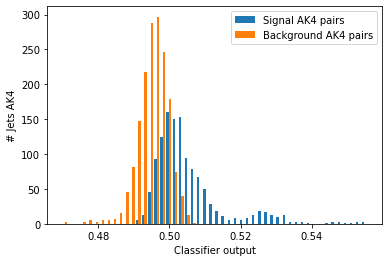

In [15]:
plt.hist([live_pred[target4_VZZ==1], live_pred[target4_VZZ==0]], 
         label=['Signal AK4 pairs', 'Background AK4 pairs'], bins=50)
plt.xlabel("Classifier output")
plt.ylabel("# Jets AK4")
plt.legend()
pass

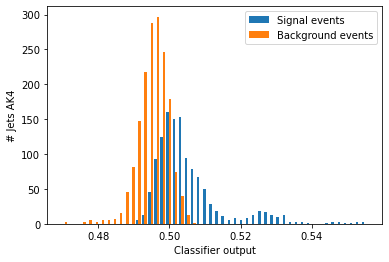

In [11]:
plt.hist([loaded_pred[target4_VZZ==1], loaded_pred[target4_VZZ==0]], 
         label=['Signal AK4 pairs', 'Background AK4 pairs'], bins=50)
plt.xlabel("Classifier output")
plt.ylabel("# Jets AK4")
plt.legend()
pass

In [14]:
loaded_pred[np.argmax(loaded_pred)]


0.5555740174266967

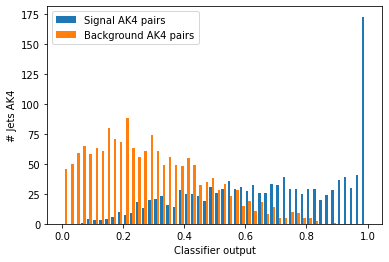

In [17]:
from scipy.special import erf

my_erf = lambda x,mean=loaded_pred.mean(),std=loaded_pred.std(): (erf((x-mean)/std) + 1)/2
spread_pred = np.vectorize(my_erf)(loaded_pred)

plt.hist([spread_pred[target4_VZZ==1], spread_pred[target4_VZZ==0]], 
         label=['Signal AK4 pairs', 'Background AK4 pairs'], bins=50)
plt.xlabel("Classifier output")
plt.ylabel("# Jets AK4")
plt.legend()
pass

In [ ]:
# Convert to script
# !jupyter nbconvert --to script config_template.ipynb

## Old stuff

In [ ]:
stop

In [ ]:
nTrees_Ada_old = np.logspace(0.5, 3., 8).astype(int)
lRate_Ada_old = np.logspace(-0.8, -0.2, 7)
grid_Ada_old = grid_Ada
nTrees_best_Ada_old = grid_Ada_old.best_params_['n_estimators']
lRate_best_Ada_old  = grid_Ada_old.best_params_['learning_rate']

In [ ]:
print ("best param choice (old): nTrees = %.2f (10^%.5f)" % (nTrees_best_Ada_old, math.log10(nTrees_best_Ada_old)))
print ("best param choice (old): lRate  = %.2f (10^%.3f)" % (lRate_best_Ada_old, math.log10(lRate_best_Ada_old)))

grid_plot(grid_Ada_old.cv_results_['mean_test_score'], nTrees_Ada_old, lRate_Ada_old, 
          lx="n trees", ly="learning rate", title="AdaBoost_old - Score", log=False, logx=False)
print("Best score (old) = %.3f" % (grid_Ada_old.best_score_))